# Sunrise Demo

## Setup

In [41]:
# %load init.py
#@title Import & Utilities
from __future__ import annotations

class AutoImportError(ImportError):
    pass

class auto(object):
    registry: ClassVar[Dict[str, Tuple[str, ...]]] = {}

    @classmethod
    def register(
        cls,
        import_name: str,
        package_name: Optional[str]=None,
        *extra_package_names: List[str],
    ):
        if package_name is None:
            package_name = import_name

        cls.registry[import_name] = (
            package_name,
            *extra_package_names,
        )

    def __getattr__(self, import_name: str):
        import subprocess, importlib, sys

        try:
            return object.__getattribute__(self, import_name)
        except AttributeError:
            pass

        module = None
        try:
            module = importlib.import_module(import_name)
        except ImportError as e:
            package_names = self.registry[import_name]

            process = subprocess.run([
                sys.executable,
                '-m', 'pip',
                'install',
                *package_names,
            ], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            if process.returncode != 0:
                raise AutoImportError(f"Failed to pip install {package_names!r}\n\n{process.stdout.read()}") from e

            try:
                module = importlib.import_module(import_name)
            except ImportError as e:
                raise AutoImportError(f'Import failed a second time, even after a pip install') from e

        assert module is not None
        # print(f'setattr({self!r}, {import_name!r}, {module!r})')
        setattr(self, import_name, module)
        return module

auto.register('tqdm')
auto.register('more_itertools', 'more-itertools')
auto.register('torch')
auto.register('peft')
auto.register('guidance')
auto.register('langchain')
auto.register('diffusers')

auto.register('transformers', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('accelerate', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('datasets', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('tokenizers', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('evaluate', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('huggingface_hub', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')

auto = auto()


def doctest(func=None, /, verbose=False, sterile=False):
    def wrapper(func):
        # Thanks https://stackoverflow.com/a/49659927
        import doctest, copy

        # I need this to error out on failure; the default one doesn't.
        def run_docstring_examples(f, globs, verbose=False, name="NoName", compileflags=None, optionflags=0):
            finder = doctest.DocTestFinder(verbose=verbose, recurse=False)
            runner = doctest.DocTestRunner(verbose=verbose, optionflags=optionflags)
            for test in finder.find(func, name, globs=globs):
                runner.run(test, compileflags=compileflags)
            assert runner.failures == 0

        name = func.__name__

        if sterile:
            globs = {}
        else:
            globs = copy.copy(globals())
        globs[name] = func
        run_docstring_examples(func, globs, verbose=verbose, name=name)
        return func

    if func is not None:
        return wrapper(func)
    else:
        return wrapper

try:
    g
except NameError:
    g = {}

try:
    f
except NameError:
    f = {}

def run(func=None, /, name=None, cond=True, splat=False, after=None, scope=None):
    def wrapper(func, /, *, name=name, cond=cond):
        import inspect

        if callable(cond):
            cond = cond()

        if not cond:
            return None

        if name is None:
            name = func.__name__
            
        f[name] = func

        args = []
        for key, parameter in inspect.signature(func).parameters.items():
            if parameter.kind == inspect.Parameter.POSITIONAL_ONLY:
                keys = [key]
                if scope is not None:
                    keys.insert(0, f'{scope}__{key}')
                
                for key in keys:
                    try:
                        value = g[key]
                    except KeyError:
                        continue
                    else:
                        args.append(value)
                        break
                else:
                    raise KeyError(f'None of {keys=!r} found in g')

        ret = func(*args)

        if callable(after):
            after(ret)

        if splat:
            it = ret.items()
        else:
            it = [(name, ret)]

        for name, ret in it:
            if scope is not None:
                name = f'{scope}__{name}'

            g[name] = ret

        return None

    if func is not None:
        return wrapper(func)
    else:
        return wrapper

@auto.IPython.core.magic.register_line_magic
@auto.IPython.core.magic.register_cell_magic
def source(magic_line, magic_cell=None):
    import os, subprocess, shlex

    if magic_cell is None or magic_cell == '':
        before = os.environ.copy()

        process = subprocess.run([
            'bash', '-c', f'source {magic_line}; export',
        ], capture_output=True, text=True)

        after = {}
        for line in process.stdout.split('\n'):
            if line == '': continue
            parts = shlex.split(line)
            assert parts[0] == 'declare', f'{line=!r}'
            assert parts[1] == '-x', f'{line=!r}'
            if '=' not in parts[2]: continue
            name, value = parts[2].split('=', 1)

            if before.get(name, None) == value: continue
            after[name] = value

        magic_cell = f'%%source {magic_line}\n'
        magic_cell += f'os.environ |= {{\n'
        for name, value in after.items():
            magic_cell += f'  {name!r}: '
            if ':' in value:
                magic_cell += f'":".join([\n'
                for value in value.split(':'):
                    magic_cell += f'    {value!r},\n'
                magic_cell += f'  ]),\n'
            else:
                magic_cell += f' {value!r},\n'
        magic_cell += f'}}\n'

        get_ipython().set_next_input(magic_cell, replace=True)

    get_ipython().run_cell(magic_cell)

In [42]:
Degree = auto.typing.NewType('Degree', float)
Radian = auto.typing.NewType('Radian', float)
Meter = auto.typing.NewType('Meter', float)
Kilometer = auto.typing.NewType('Kilometer', float)

In [61]:
def convert_location_to_spatial(
    *,
    lat: Degree,
    lng: Degree,
    alt: Meter,
    math=auto.math,
) -> Tuple[Meter, Meter, Meter]:
    # Thanks https://gis.stackexchange.com/a/4148
    
    #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and 
    #> phi/theta/rho are just another name for latitude, longitude, and altitude.
    #> :) (A minor difference: altitude is usually measured from the surface of the 
    #> sphere; rho is measured from the center -- to convert, just add/subtract the 
    #> radius of the sphere.)
    phi: Radian = math.radians(lat)
    theta: Radian = math.radians(lng)
    
    # Thanks https://en.wikipedia.org/wiki/Earth_radius
    #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
    rho: Meter = 6_371_000 + alt
    
    #> x = math.cos(phi) * math.cos(theta) * rho
    x: Meter = math.cos(phi) * math.cos(theta) * rho
    
    #> y = math.cos(phi) * math.sin(theta) * rho
    y: Meter = math.cos(phi) * math.sin(theta) * rho

    #> z = math.sin(phi) * rho # z is 'up'
    z: Meter = math.sin(phi) * rho
    
    #> (Note there's some slightly arbitrary choices here in what each axis means...
    #> you might want 'y' to point at the north pole instead of 'z', for example.)
    
    # I do :)
    y, z = z, y
    
    return x, y, z

In [44]:
@doctest
def convert_tile_coordinates_to_latlng(
    *,
    z: int,
    x: int,
    y: int,
    math=auto.math,
    return_google_maps_url: bool=False,
) -> Tuple[Degree, Degree]:
    r"""

    >>> convert_tile_coordinates_to_latlng(z=15, x=8739, y=12925, return_google_maps_url=True)
    'https://www.google.com/maps/@35.48751102385376,-83.990478515625,15.79z?entry=ttu'

    """
    
    # Thanks https://gis.stackexchange.com/a/133535
    
    #> n = 2 ^ zoom
    n = math.pow(2, z)
    
    #> lon_deg = xtile / n * 360.0 - 180.0
    lon_deg = x / n * 360.0 - 180.0
    
    #> lat_rad = arctan(sinh(π * (1 - 2 * ytile / n)))
    lat_rad = math.atan(math.sinh(math.pi * (1.0 - 2.0 * y / n)))
    
    #> lat_deg = lat_rad * 180.0 / π
    lat_deg = lat_rad * 180.0 / math.pi
    
    if return_google_maps_url:
        return f"""https://www.google.com/maps/@{lat_deg},{lon_deg},15.79z?entry=ttu"""
    
    return lat_deg, lon_deg

In [45]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Coord:
    """Tile image coordinates for mapbox/etc services"""
    z: int
    x: int
    y: int

    @property
    def nw(self) -> Location:
        """North-West lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.x,
            y=self.y,
        )
        return Location(lat=lat, lng=lng)

    @property
    def se(self) -> Location:
        """South-East lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.x + 1,
            y=self.y + 1,
        )
        return Location(lat=lat, lng=lng)

@auto.dataclasses.dataclass(eq=True, frozen=True)
class Domain:
    """Lower (inclusive) and upper (inclusive) bounds of latitude/longitude"""
    lo: Coord
    hi: Coord
        
    @property
    def coords(self) -> List[Coord]:
        """All coordinates within lower/upper bounds"""
        coords = []
        for z, x, y in auto.itertools.product(
            range(self.lo.z, 1+self.hi.z),
            range(self.lo.x, 1+self.hi.x),
            range(self.lo.y, 1+self.hi.y),
        ):
            coords.append(Coord(
                z=z,
                x=x,
                y=y,
            ))
        
        return coords

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Location:
    """Geographical latitude/longitude"""
    lat: float
    lng: float
    alt: Optional[float] = auto.dataclasses.field(default=None)

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Point:
    x: float
    y: float
    z: float

In [46]:
@auto.dataclasses.dataclass
class TileURL:
    scheme: str
    netloc: str
    prefix: str
    z: int
    x: int
    y: int
    suffix: str
    query: Dict[str, str]
    fragment: str

    @classmethod
    @doctest
    def decode(cls, url: str) -> Self:
        r"""
        
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov',
         'prefix': ['', 'styles', 'v1', 'atlas-user', 'ck58pyquo009v01p99xebegr9', 'tiles', '256'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '@2x',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov:443',
         'prefix': ['', 'v4', 'atlas-user.0000214_pink'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '.png',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        
        """
        
        scheme, netloc, path, query, fragment = auto.urllib.parse.urlsplit(
            url,
        )
        path = path.split('/')
        *prefix, z, x, suffix = path
        assert (match := auto.re.match(r'^(\d+)(.*)$', suffix)) is not None, \
            f'{suffix = !r}'
        y, suffix = match.groups()
            
        
        z, x, y = map(int, (z, x, y))
        query = auto.urllib.parse.parse_qsl(
            query,
        )

        return cls(
            scheme=scheme,
            netloc=netloc,
            prefix=prefix,
            z=z,
            x=x,
            y=y,
            suffix=suffix,
            query=query,
            fragment=fragment,
        )

    def encode(self) -> str:
        query = auto.urllib.parse.urlencode(
            self.query,
            doseq=True,
        )
        
        z, x, y = map(str, (self.z, self.x, self.y))

        path = '/'.join([
            *self.prefix,
            z,
            x,
            y + self.suffix,
        ])

        return auto.urllib.parse.urlunsplit((
            self.scheme,
            self.netloc,
            path,
            query,
            self.fragment,
        ))

In [47]:
@run(cond='cache' not in g)
def cache():
    return {}

@run
def cache(cache, /):
    def load() -> Dict:
        ret = {}
        try:
            with open(path, 'rb') as f:
                ret = auto.pickle.load(f)
                print(f'Read {f.tell():,d} bytes from {path}')
        except Exception as e:
            print('load failed:')
            auto.traceback.print_exception(e)
        
        return ret
    
    def merge(mutable: Dict, constant: Dict):
        try:
            for k, v in constant.items():
                if k in mutable:
                    continue

                mutable[k] = v
        except Exception as e:
            print('merge failed:')
            auto.traceback.print_exception(e)
    
    def dump(d: Dict):
        try:
            with open(path, 'wb') as f:
                auto.pickle.dump(d, f)

                print(f'Wrote {f.tell():,d} bytes to {path}')
        except Exception as e:
            print('dump failed:')
            auto.traceback.print_exception(e)
        
    path = auto.pathlib.Path.cwd() / 'tmp' / 'Sunrise Demo Cache.pickle'
    path.parent.mkdir(parents=False, exist_ok=True)
    
    if path.exists():
        merge(cache, load())
    
    dump(cache)
    
    return cache

Read 1,744,525 bytes from /home/thobson2/src/Sunrise-Demo/tmp/Sunrise Demo Cache.pickle
Wrote 14,473,750 bytes to /home/thobson2/src/Sunrise-Demo/tmp/Sunrise Demo Cache.pickle


In [48]:
@run
def fetch(cache, /):
    def fetch(url: str, *, tqdm=None) -> bytes:
        key = url
        if key not in cache:
            if tqdm is not None:
                tqdm.set_description(f'Cache Miss: {url}')

            with auto.requests.get(url) as r:
                cache[key] = r.content
            
            auto.time.sleep(1)
        
        else:
            if tqdm is not None:
                tqdm.set_description('Cache Hit: {url}')
        
        return cache[key]

    return fetch

## Background

In [49]:
@run(after=auto.pprint.pp, scope='background')
def domain():
    from bs4 import BeautifulSoup
    
    soup = BeautifulSoup(r'''
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    ''', 'html.parser')
    
    urls = []
    for img in soup('img'):
        src = img['src']
        url = TileURL.decode(src)
        urls.append(url)
    
    return Domain(
        lo=Coord(
            z=min(url.z for url in urls),
            x=min(url.x for url in urls),
            y=min(url.y for url in urls),
        ),
        hi=Coord(
            z=max(url.z for url in urls),
            x=max(url.x for url in urls),
            y=max(url.y for url in urls),
        ),
    )

Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808))


In [50]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Tile:
    coord: Coord
    url: str = auto.dataclasses.field(repr=False)
    image_data: bytes = auto.dataclasses.field(repr=False)
    
    @auto.functools.cached_property
    def image(self) -> auto.PIL.Image.Image:
        auto.PIL; from PIL import Image
        
        with auto.io.BytesIO(self.image_data) as f:
            image = auto.PIL.Image.open(f)
            image.load()
            
            image = image.convert('RGB')
        
        return image
    
    @auto.functools.cached_property
    def image_array(self) -> auto.numpy.ndarray[tuple[int, int, Literal[3]], auto.numpy.uint8]:
        image = auto.numpy.array(self.image)
        match image.shape:
            case (w, h, 3):
                pass
            case _:
                assert False, \
                    f"Wrong shape: {image.shape}"
        
        return image
    
    @auto.functools.cached_property
    def location(self) -> np.ndarray[tuple[Any, Any, Literal[2]], np.float32]:
        nr, nc, _ = self.image_array.shape
        assert nr == nc, \
            f"Expected square image"
        res = nr
        
        # Thanks https://stackoverflow.com/a/57025941
        assert (res != 0) and (res & (res - 1) == 0), \
            f"""Expected resolution to be power-of-two: {res=!r}"""
        
        dz = int(auto.math.log2(res))
        
        # I'm given an array of size (res)x(res).
        #
        # I need to produce an array of lat/lng coordinates.
        #
        # I could return the center coordinates (abcdef below).
        #
        # However, if I want tiles to be stitched seamlessly,
        # then I should return the intersection coordinates (x's below).
        #
        # x-x-x-x
        # |a|b|c|
        # x x x x
        # |d|e|f|
        # x-x-x-x
        
        latlng = np.zeros(
            shape=(res+1, res+1, 2),
            dtype=np.float32,
        )
        
        for xi, yi in auto.itertools.product(
            range(res),
            range(res),
        ):
            z = self.coord.z + dz
            x = self.coord.x * res + xi + 0.5
            y = self.coord.y * res + yi + 0.5
            
            lat, lng = convert_tile_coordinates_to_latlng(
                z=z,
                x=x,
                y=y,
            )
            
            latlng[yi, xi, 0] = lat
            latlng[yi, xi, 1] = lng
        
        return latlng

@run(scope='background', after=lambda x: print(len(x)))
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
    )):
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image_data = fetch(url, tqdm=tqdm)
        
        if image_data == b'{"message":"Tile does not exist"}':
            continue
            
        tiles.append(Tile(
            coord=coord,
            url=url,
            image_data=image_data,
        ))

    return tiles

Cache Hit: {url}: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 945.38it/s]

24


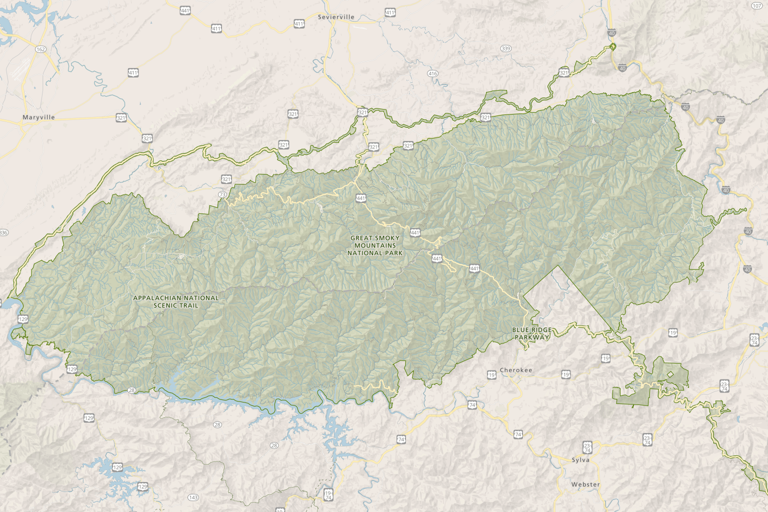

In [51]:
auto.register('PIL', 'Pillow')

@run(scope='background', after=auto.IPython.display.display)
def __stitch_tiles(tiles, /):
    auto.PIL; from PIL import Image
    
    xs = set(tile.coord.x for tile in tiles)
    ys = set(tile.coord.y for tile in tiles)
    
    xs = sorted(xs)
    ys = sorted(ys)
    
    nx = len(xs)
    ny = len(ys)
    
    sz = 128
    
    composite = Image.new('RGB', (nx*sz, ny*sz))
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        image = tile.image.copy()
        image.thumbnail((sz, sz))

        composite.paste(image, (xi*sz, yi*sz))
    
    return composite

## Elevation

In [52]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class ElevationTile(Tile):
    @auto.functools.cached_property
    def altitude(self) -> auto.numpy.ndarray[tuple[int, int, 1], Meter]:
        rgb = self.image_array
        h, w, _ = rgb.shape
        
        # Thanks https://docs.mapbox.com/data/tilesets/guides/access-elevation-data/#decode-data
        #> elevation = -10000 + (({R} * 256 * 256 + {G} * 256 + {B}) * 0.1)
        
        altitude = np.zeros(
            shape=(h, w, 1),
            dtype=np.float32,
        )
        
        altitude += rgb[:, :, 0] * (1 * 256 * 256)
        altitude += rgb[:, :, 1] * (1 * 256)
        altitude += rgb[:, :, 2] * (1)
        altitude *= 0.1
        altitude -= 10000
        
        return altitude

@run(scope='elevation')
def domain(background__domain, /):
    return background__domain

@run(scope='elevation')
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://api.mapbox.com/v4/mapbox.terrain-rgb/14/3826/6127@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
    )) -> URL:
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image_data = fetch(url, tqdm=tqdm)
        
        tiles.append(ElevationTile(
            coord=coord,
            url=url,
            image_data=image_data,
        ))
    
    return tiles

Cache Hit: {url}: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1215.29it/s]


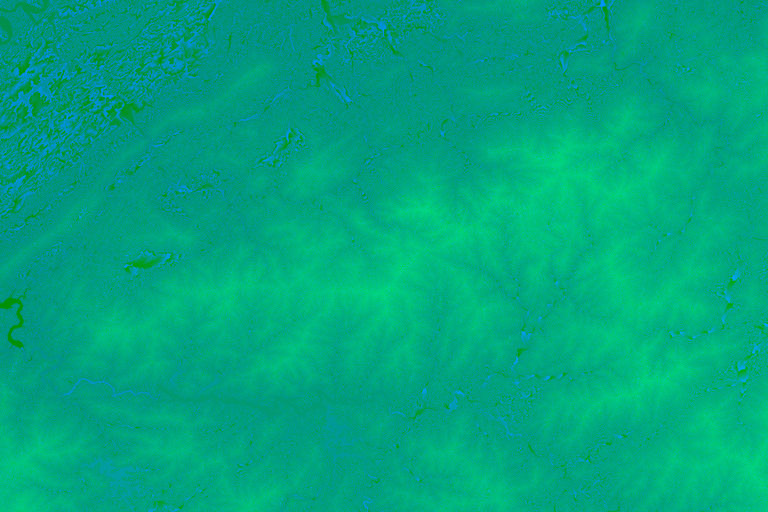

In [53]:
f['__stitch_tiles'](g['elevation__tiles'])

## Observations

In [54]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Observation:
    common_name: str
    irma_id: str
    latin_name_ref: str
    latin_name: str

@run
def observations(fetch, /):
    observations = []
    for observation in (
        Observation(**kwargs)
        for kwargs in (
            auto.json.loads(fetch('https://species.atlasofthesmokies.org/atbirecords/lexical_index.json'))
        )['items']
    ):
        observations.append(observation)
    
    return observations

In [55]:
@run(after=print)
def observation(observations, /):
    for observation in observations:
        if observation.common_name not in [
            'A Spiny Crawler Mayfly',
            'Acadian Flycatcher',
            'Agreeable Tiger Moth',
        ]:
            continue
        
        return observation

Observation(common_name='Acadian Flycatcher', irma_id='0013547', latin_name_ref='Empidonax virescens', latin_name='Empidonax_virescens')


In [56]:
@run(scope='observation', after=print)
def domain():
    from bs4 import BeautifulSoup
    
    soup = BeautifulSoup('''
    <img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/547/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/805.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;">
    <img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/547/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/805.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/551/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/551/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;">
    <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/548/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/548/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/549/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/547/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/550/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/547/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/550/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/546/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/551/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/551/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/548/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/549/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/547/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/546/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    ''', 'html.parser')
    
    urls = []
    for img in soup('img'):
        src = img['src']
        try:
            url = TileURL.decode(src)
        except:
#             print(f'Bad! {src=!r}')
            pass
        else:
            urls.append(url)
    
    return Domain(
        lo=Coord(
            z=min(url.z for url in urls),
            x=min(url.x for url in urls),
            y=min(url.y for url in urls),
        ),
        hi=Coord(
            z=max(url.z for url in urls),
            x=max(url.x for url in urls),
            y=max(url.y for url in urls),
        ),
    )

Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808))


In [57]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class ObservationTile(Tile):
    @auto.functools.cached_property
    def amount(self) -> auto.numpy.ndarray[tuple[int, int, Literal[1]], auto.numpy.uint8]:
        rgb = self.image_array
        nr, nc, _ = rgb.shape
        
        # Thanks https://species.atlasofthesmokies.org/style.css
        pinks = auto.numpy.array([
            # Black, obviously.
            # Represents 0-25%
            [0, 0, 0],
            
            #> #legend-pink-50 { background-color: #f069a3; }
            # Represents 25-50%
            [247, 105, 164],
            
            #> #legend-pink-75 { background-color: #c31d8e; }
            # Represents 50-75%
            [196, 28, 142],
            
            #> #legend-pink-100 { background-color: #752879; }
            # Represents 75-100%
            [121, 0, 124],
        ], dtype=auto.numpy.uint8)
        
        amount = auto.numpy.zeros(
            shape=(nr, nc, 1),
            dtype=auto.numpy.uint8,
        )
        
        for ri, ci in auto.itertools.product(
            range(nr),
            range(nc),
        ):
            color = rgb[ri, ci, :]
            dists = []
            for pink in pinks:
                dist = auto.numpy.sqrt(auto.numpy.sum((color - pink) ** 2))
                dists.append(dist)

            amount[ri, ci] = auto.numpy.argmin(dists)
        
        return amount
        
@run(scope='observation')
def tiles(domain, observation, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
    )) -> TileURL:
        return auto.dataclasses.replace(
            url,
            prefix=['v4', f'atlas-user.{observation.irma_id}_pink'],
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image_data = fetch(url, tqdm=tqdm)
        if image_data == b'{"message":"Tile does not exist"}':
            continue
        
        tiles.append(ObservationTile(
            coord=coord,
            url=url,
            image_data=image_data,
        ))
    
    return tiles

Cache Hit: {url}: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1026.38it/s]


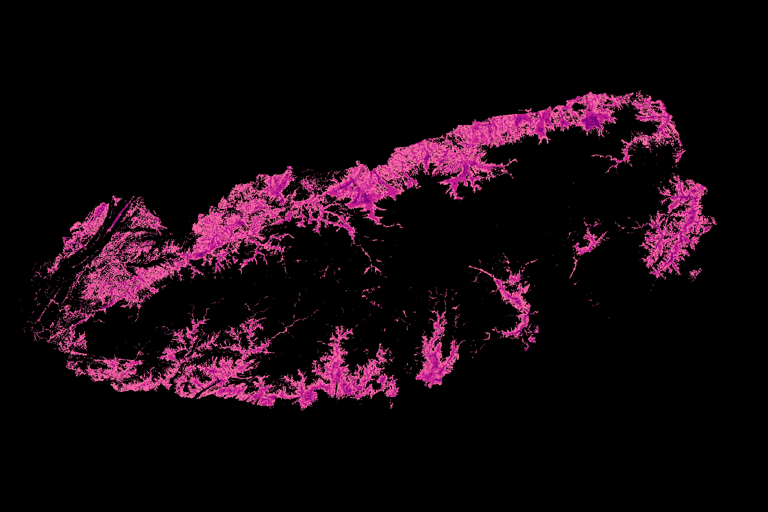

In [58]:
f['__stitch_tiles'](g['observation__tiles'])

## OSPRay

In [60]:
@run(scope='observation')
def __estimate_data_sizes(tiles, /):
    from PIL import Image
    
    nx = len(set(tile.coord.x for tile in tiles))
    ny = len(set(tile.coord.y for tile in tiles))
    
    for tile in tiles:
        image = tile.image

        width = image.width
        height = image.height

        assert width == height, \
            f'non-square {width=} {height=}'

    resolution = width
    x_resolution = nx*resolution
    y_resolution = ny*resolution
    print(f"""For an 2D RGB texture of uint8_t of size { x_resolution :,d}x{ y_resolution :,d}:""")
    texture_bytes = 4 * x_resolution * y_resolution
    print(f"""  the file would be { texture_bytes :,d} bytes""")
    
    print(f"""For a triangle mesh:""")
    n_vertices = (x_resolution) * (y_resolution)
    print(f"""  number of vertices = { n_vertices :,d} ({ 3*4*n_vertices :,d} bytes of vec3f data)""")
    n_edges = x_resolution * y_resolution * 3
    print(f"""  number of edges = { n_edges :,d} ({ 4*4*n_edges :,d} bytes of vec4ui data)""")

For an 2D RGB texture of uint8_t of size 1,536x1,024:
  the file would be 6,291,456 bytes
For a triangle mesh:
  number of vertices = 1,572,864 (18,874,368 bytes of vec3f data)
  number of edges = 4,718,592 (75,497,472 bytes of vec4ui data)


In [20]:
@run(scope='elevation', after=print)
def __generate_mesh(domain, tiles, /):
    root = auto.pathlib.Path.home() / 'src' / 'Sunrise-Demo' / 'data'
    root.mkdir(parents=True, exist_ok=True)
    
    with auto.contextlib.ExitStack() as stack:
        @auto.contextlib.contextmanager
        def open(path, mode, /):
            fileobj = None
            try:
                fileobj = auto.builtins.open(path, mode)
                yield fileobj
            finally:
                try:
                    print(f'Wrote {fileobj.tell():,d} bytes to {path}')
                except:
                    pass
            
        def emit(name, format, /, *values, cache={}):
            try:
                fileobj = cache[name]
            except KeyError:
                fileobj = cache[name] = stack.enter_context(open(root / name, 'wb'))
            
            fileobj.write(auto.struct.pack(format, *values))

        xs = sorted(set(tile.coord.x for tile in tiles))
        ys = sorted(set(tile.coord.y for tile in tiles))
    
    
            
        X, Y, Z = convert_location_to_spatial(
            lat=elevation.latlng[:, :, 0],
            lng=elevation.latlng[:, :, 1],
            alt=elevation.altitude,
            radians=auto.numpy.radians,
            cos=auto.numpy.cos,
            sin=auto.numpy.sin,
        )
        
        nr = X.shape[0]
        nc = X.shape[1]
        
        index = auto.numpy.zeros(
            shape=(nr, nc),
            dtype=auto.numpy.uint32,
        )
        
        for i, (ri, ci) in enumerate(auto.itertools.product(range(nr), range(nc))):
            index[ri, ci] = i
            
            x: Meter = X[ri, ci]
            y: Meter = Y[ri, ci]
            z: Meter = Z[ri, ci]
            
            x: Kilometer = x/1000.0
            y: Kilometer = y/1000.0
            z: Kilometer = z/1000.0
            
            emit('OSPGeometry.mesh.vertex.position.vec3f.bin', 'fff',
                 x,
                 y,
                 z,
            )
            
        # a -1- b
        # |     |
        # 4     2
        # |     |
        # d -3- c
        
        for ri, ci in auto.itertools.product(
            range(0, nr-1),
            range(0, nc-1),
        ):
            a = index[ri+0, ci+0]
            b = index[ri+0, ci+1]
            c = index[ri+1, ci+1]
            d = index[ri+1, ci+0]
            
            emit('OSPGeometry.mesh.index.vec4ui.bin', 'IIII',
                 a,
                 b,
                 c,
                 d,
            )

Elevation(domain=Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808)), altitude=array([[ 301.7998,  307.    ,  311.7002, ...,  515.2002,  528.4004,
         542.2998],
       [ 304.2998,  310.    ,  313.5   , ...,  524.4004,  536.2002,
         550.7998],
       [ 304.7002,  310.4004,  313.5   , ...,  535.7998,  545.1006,
         560.2002],
       ...,
       [1469.9004, 1469.2998, 1469.9004, ..., 1620.4004, 1626.7002,
        1633.4004],
       [1481.    , 1481.2002, 1481.2998, ..., 1613.7998, 1622.1006,
        1626.9004],
       [1495.2998, 1492.6006, 1491.6006, ..., 1610.5   , 1616.6006,
        1624.7002]], dtype=float32), latlng=array([[[ 35.888912, -84.02327 ],
        [ 35.888912, -84.02292 ],
        [ 35.888912, -84.02258 ],
        ...,
        [ 35.888912, -82.969604],
        [ 35.888912, -82.96927 ],
        [ 35.888912, -82.96892 ]],

       [[ 35.888634, -84.02327 ],
        [ 35.888634, -84.02292 ],
        [ 35.888634, -84.02258 ],
        ...,
        

In [ ]:
@run
def __observation_stitched(observation__tiles, /):
    pass

In [ ]:
@run
def __generate_mesh(background__tiles, elevation__tiles, observation__tiles, /):
    root = auto.pathlib.Path.home() / 'src' / 'Sunrise-Demo' / 'data'
    root.mkdir(parents=True, exist_ok=True)
    
    with auto.contextlib.ExitStack() as stack:
        @auto.contextlib.contextmanager
        def open(path, mode, /):
            fileobj = None
            try:
                fileobj = auto.builtins.open(path, mode)
                yield fileobj
            finally:
                try:
                    print(f'Wrote {fileobj.tell():,d} bytes to {path}')
                except:
                    pass
            
        def emit(name, format, /, *values, cache={}):
            try:
                fileobj = cache[name]
            except KeyError:
                fileobj = cache[name] = stack.enter_context(open(root / name, 'wb'))
            
            fileobj.write(auto.struct.pack(format, *values))
            
        coords = set()
        for tiles in [
            background__tiles,
            elevation__tiles,
            observation__tiles,
        ]:
            for tile in tiles:
                coords.add(tile.coord)
        
        assert len(set(coord.z for coord in coords)) == 1, \
            f"Expe

In [63]:
@run
def __generate_mesh(background__tiles, elevation__tiles, observation__tiles, /):
    np = auto.numpy
    
    root = auto.pathlib.Path.home() / 'src' / 'Sunrise-Demo' / 'data'
    root.mkdir(parents=True, exist_ok=True)
    
    with auto.contextlib.ExitStack() as stack:
        @auto.contextlib.contextmanager
        def open(path, /, mode='wb'):
            path = auto.pathlib.Path(path)
            path.parents.mkdir(parents=False, exist_ok=True)
            
            fileobj = None
            try:
                fileobj = auto.builtins.open(path, mode)
                yield fileobj
            finally:
                try:
                    print(f'Wrote {fileobj.tell():,d} bytes to {path}')
                except:
                    pass
            
        def emit(name, format, /, *values, cache={}):
            try:
                fileobj = cache[name]
            except KeyError:
                fileobj = cache[name] = stack.enter_context(open(root / name, 'wb'))
            
            fileobj.write(auto.struct.pack(format, *values))
            
        coords = set()
        lookup = {}
        resolutions = set()
        for name, tiles in [
            ('background', background__tiles),
            ('elevation', elevation__tiles),
            ('observation', observation__tiles),
        ]:
            lookup[name] = {}
            for tile in tiles:
                coords.add(tile.coord)
                lookup[name][tile.coord] = tile
                resolutions.add(tile.image_array.shape[0])
                
        assert len(resolutions) == 1, \
            f"Expected a single resolution: {resolutions}"
        res = next(iter(resolutions))
        
        xs = sorted(set(coord.x for coord in coords))
        ys = sorted(set(coord.y for coord in coords))
        zs = sorted(set(coord.z for coord in coords))
        assert len(zs) == 1, \
            f"Expected every tile to be at the same zoom level: {zs}"
        
        background: np.ndarray[tuple[int, int, Literal[3]], np.float32] = np.zeros(
            shape=(len(ys)*res, len(xs)*res, 3),
            dtype=np.float32,
        )
        for tile in background__tiles:
            yi = ys.index(tile.coord.y)
            xi = xs.index(tile.coord.x)
            
            background[
                (yi+0)*res:(yi+1)*res,
                (xi+0)*res:(xi+1)*res,
                0:3,
            ] = tile.image_array
        
        position: np.ndarray[tuple[int, int, Literal[3]], np.float32] = np.zeros(
            shape=(len(ys), len(xs), 3),
            dtype=np.float32,
        )
        for tile in elevation__tiles:
            yi = ys.index(tile.coord.y)
            xi = xs.index(tile.coord.x)
            
            position[
                (yi+0)*res:(yi+1)*res,
                (xi+0)*res:(xi+1)*res,
                0:3,
            ] = np.concatenate(
                convert_location_to_spatial(
                    lat=tile.location[:, :, 0],
                    lng=tile.location[:, :, 1],
                    alt=tile.altitude[:, :, 0],
                    math=np,
                ),
                axis=2,
            )
        
        color = np.zeros(
            shape=(len(ys), len(xs), 3),
            dtype=np.float32,
        )
    
        for i, coord in enumerate(coords):
            background = lookup['background'][coord]
            elevation = lookup['elevation'][coord]
            observation = lookup['observation'].get(coord, None)
            
            background = background.image_array
            location = elevation.location
            altitude = elevation.altitude
            if observation is not None:
                observation = observation.amount
            
            X, Y, Z = convert_location_to_spatial(
                lat=location[:, :, 0],
                lng=location[:, :, 1],
                alt=altitude[:, :, 0],
                math=auto.numpy,
            )
            
            index = {}
            for ri, ci in auto.itertools.product(range(res), range(res)):
                index[ri, ci] = len(index)
                
                emit(f'{i}/OSPGeometry.mesh.vertex.position.vec3f.bin', 'fff',
                    X[ri, ci] / 1000.0,
                    Y[ri, ci] / 1000.0,
                    Z[ri, ci] / 1000.0,
                )
                
                emit(f'{i}/OSPGeometry.mesh.)

            # a -1- b
            # |     |
            # 4     2
            # |     |
            # d -3- c

            for ri, ci in auto.itertools.product(
                range(0, res-1),
                range(0, res-1),
            ):
                a = index[ri+0, ci+0]
                b = index[ri+0, ci+1]
                c = index[ri+1, ci+1]
                d = index[ri+1, ci+0]

                emit(f'{i}/OSPGeometry.mesh.index.vec4ui.bin', 'IIII',
                     a,
                     b,
                     c,
                     d,
                )
            

In [62]:
            
        X, Y, Z = convert_location_to_spatial(
            lat=elevation.latlng[:, :, 0],
            lng=elevation.latlng[:, :, 1],
            alt=elevation.altitude,
            math=auto.numpy,
        )
        
        nr = X.shape[0]
        nc = X.shape[1]
        
        index = auto.numpy.zeros(
            shape=(nr, nc),
            dtype=auto.numpy.uint32,
        )
        
        for i, (ri, ci) in enumerate(auto.itertools.product(range(nr), range(nc))):
            index[ri, ci] = i
            
            x: Meter = X[ri, ci]
            y: Meter = Y[ri, ci]
            z: Meter = Z[ri, ci]
            
            x: Kilometer = x/1000.0
            y: Kilometer = y/1000.0
            z: Kilometer = z/1000.0
            
            emit('OSPGeometry.mesh.vertex.position.vec3f.bin', 'fff',
                 x,
                 y,
                 z,
            )
            
        # a -1- b
        # |     |
        # 4     2
        # |     |
        # d -3- c
        
        for ri, ci in auto.itertools.product(
            range(0, nr-1),
            range(0, nc-1),
        ):
            a = index[ri+0, ci+0]
            b = index[ri+0, ci+1]
            c = index[ri+1, ci+1]
            d = index[ri+1, ci+0]
            
            emit('OSPGeometry.mesh.index.vec4ui.bin', 'IIII',
                 a,
                 b,
                 c,
                 d,
            )

NameError: name 'elevation' is not defined

In [22]:
@run
def __camera_coordinates():
    # Thanks https://goo.gl/maps/H1VA3JLmxDk1yet87
    #> 35.463052, -83.303618
    src_lat, src_lng = 35.463052, -83.303618
    src_alt: Meter = 4_000
    
    # Thanks https://goo.gl/maps/PAKfxb4V6Syi5Ey89
    #> 35.608497, -83.433703
    tgt_lat, tgt_lng = 35.608497, -83.433703
    tgt_alt: Meter = 2_000
    
    src_x, src_y, src_z = map(lambda x: x/1000, convert_location_to_spatial(
        lat=src_lat,
        lng=src_lng,
        alt=src_alt,
    ))
    
    tgt_x, tgt_y, tgt_z = map(lambda x: x/1000, convert_location_to_spatial(
        lat=tgt_lat,
        lng=tgt_lng,
        alt=tgt_alt,
    ))
    
    print(f"""Position (Source):
{src_x}, {src_y}, {src_z}
Position (Target):
{tgt_x}, {tgt_y}, {tgt_z}
Direction:
{tgt_x-src_x}, {tgt_y-src_y}, {tgt_z-src_z}""")

Position (Source):
605.4723018876853, 3698.6337364380356, -5156.950336713477
Position (Target):
592.5008450055809, 3710.6381257181056, -5147.352372689759
Direction:
-12.971456882104349, 12.004389280069972, 9.597964023717395


In [29]:
@run
def __camera_coordinates():
    src, dst = {
        "x": -83.70425994533166,
        "y": 35.57451146678854,
    }, {
        "x": -83.65899807857282,
        "y": 35.58174805423522,
    }
    
    src_lat, src_lng = src["y"], src["x"]
    src_alt: Meter = 2_000
    
    tgt_lat, tgt_lng = dst["y"], dst["x"]
    tgt_alt: Meter = 1_500
    
    src_x, src_y, src_z = map(lambda x: x/1000, convert_location_to_spatial(
        lat=src_lat,
        lng=src_lng,
        alt=src_alt,
    ))
    
    tgt_x, tgt_y, tgt_z = map(lambda x: x/1000, convert_location_to_spatial(
        lat=tgt_lat,
        lng=tgt_lng,
        alt=tgt_alt,
    ))
    
    print(f"""Position (Source):
{src_x}, {src_y}, {src_z}
Up:
{src_x}, {src_y}, {src_z}
Position (Target):
{tgt_x}, {tgt_y}, {tgt_z}
Direction:
{tgt_x-src_x}, {tgt_y-src_y}, {tgt_z-src_z}""")

Position (Source):
568.4292304733369, 3707.5641117842542, -5152.27964758833
Up:
568.4292304733369, 3707.5641117842542, -5152.27964758833
Position (Target):
572.4025565612891, 3707.9278432842643, -5150.959393379005
Direction:
3.9733260879521595, 0.3637315000100898, 1.3202542093249576


In [23]:
@run
def colors():
    return ['pink', 'blue', 'orange']

## Test

exec /home/thobson2/src/Sunrise-Demo/go.sh docker exec /home/thobson2/src/Sunrise-Demo/go.sh cmake build
exec docker exec --tty --interactive --detach-keys=ctrl-q\,ctrl-q --user 1007:1007 --workdir /home/thobson2/src/Sunrise-Demo --env USER --env HOSTNAME sunrise-demo /home/thobson2/src/Sunrise-Demo/go.sh cmake build
exec cmake --build /home/thobson2/src/Sunrise-Demo/build
Consolidate compiler generated dependencies of target main
[ 50%] Building CXX object CMakeFiles/main.dir/src/main.cpp.o
[100%] Linking CXX executable main
[100%] Built target main
exec /home/thobson2/src/Sunrise-Demo/go.sh docker exec /home/thobson2/src/Sunrise-Demo/build/main
exec docker exec --tty --interactive --detach-keys=ctrl-q\,ctrl-q --user 1007:1007 --workdir /home/thobson2/src/Sunrise-Demo --env USER --env HOSTNAME sunrise-demo /home/thobson2/src/Sunrise-Demo/build/main
bounds: 537.464417 3683.435303 -5171.443359 ;; 636.497559 3735.357666 -5123.087891
Wrote 262638 bytes to out.png


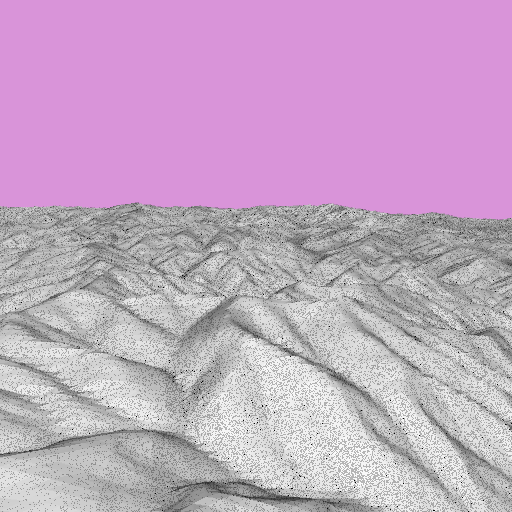

In [32]:
!test -f ./src/main.cpp && rm -f ./build/main && ./go.sh build
!test -f ./build/main && rm -f ./out.png && ./go.sh main
auto.pathlib.Path('out.png').exists() and auto.IPython.display.Image(
    filename='./out.png',
    embed=True,
)